In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing  
from sklearn.impute import SimpleImputer  
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from pprint import pprint
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [3]:
import copy as cp

In [4]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


In [7]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

In [8]:
def cross_val_predict(model, kfold, X , y):

    model = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 
    total_acc = []

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X.loc[train_ndx], y[train_ndx], X.loc[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model.predict(test_X))
        total_acc.append(accuracy_score(actual_classes,predicted_classes))
 
    return actual_classes, predicted_classes, round(np.mean(total_acc),2),model

In [9]:
def plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [11]:
def plot_cross_val_roc(kfold,clfs,X,y):

  # Run classifier with cross-validation and plot ROC curves
  for clf in clfs:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(kfold.split(X, y)):
        clf.fit(X.loc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            clf,
            X.loc[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

In [12]:
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}

# Heart Disease Data

In [13]:
df_hd = pd.read_csv('/content/drive/My Drive/5155-hw2/heart_cleveland_upload.csv')

In [14]:
df_hd

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


In [15]:
df_hd.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

# Check variable distribution

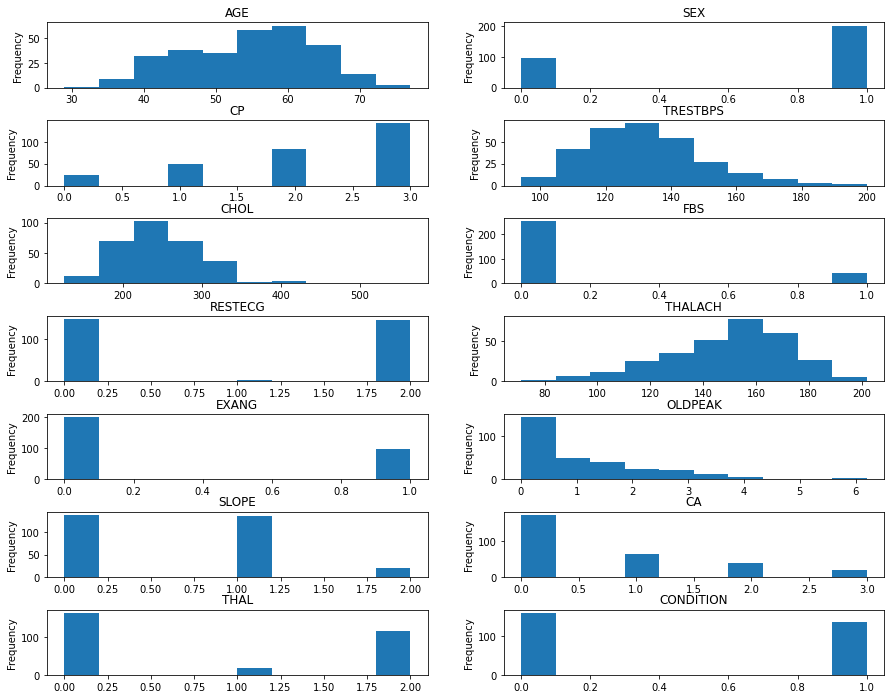

In [16]:
# define subplot grid
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
for i,ax in zip(df_hd.columns,axs.ravel()):
  df_hd[i].plot(ax=ax,kind = 'hist')
  ax.set_title(i.upper())

In [17]:
X = df_hd.loc[:,'age':'thal']

In [18]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0


# Data Preprocessing

In [19]:
cate_var = ['sex','cp','fbs','restecg','exang','slope','ca']

In [22]:
num_var = ['age','trestbps','chol','thalach','oldpeak']

In [21]:
X.loc[:,cate_var] = X.loc[:,cate_var].astype('category')

In [23]:
X.loc[:,num_var] = preprocessing.scale(X.loc[:,num_var])

In [27]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1.600302,1,0,1.596266,-0.257179,1,2,-0.812095,0,-0.820813,1,1,0
1,1.600302,0,0,0.468418,-0.160859,0,0,0.061157,0,0.639470,0,2,0
2,1.268242,0,0,1.032342,-0.411292,0,0,-1.554358,0,1.326662,2,0,0
3,1.157555,1,0,0.355633,0.667499,1,2,1.065396,0,0.295874,1,1,0
4,1.046868,1,0,-1.223355,-0.700254,0,2,-0.244481,1,0.639470,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,-1.609620,1,3,1.145127,-0.469085,0,0,1.371034,0,-0.906712,0,0,2
293,-1.720306,1,3,-0.772215,-0.546141,0,0,-0.419131,0,0.124076,1,0,2
294,-2.163054,1,3,-0.659431,-0.950688,0,0,-0.855757,1,0.467672,1,0,2
295,-2.163054,0,3,0.355633,-1.239649,0,0,1.414697,0,0.295874,0,0,0


In [28]:
dummies = pd.get_dummies(X[cate_var])

In [30]:
merged = pd.concat([X,dummies],axis = 'columns')

In [40]:
merged

,age,trestbps,chol,thalach,oldpeak,thal,sex_0,sex_1,cp_0,cp_1,...,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3
0,1.600302,1.596266,-0.257179,-0.812095,-0.820813,0,0,1,1,0,...,1,1,0,0,1,0,0,1,0,0
1,1.600302,0.468418,-0.160859,0.061157,0.639470,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,1.268242,1.032342,-0.411292,-1.554358,1.326662,0,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0
3,1.157555,0.355633,0.667499,1.065396,0.295874,0,0,1,1,0,...,1,1,0,0,1,0,0,1,0,0
4,1.046868,-1.223355,-0.700254,-0.244481,0.639470,0,0,1,1,0,...,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,-1.609620,1.145127,-0.469085,1.371034,-0.906712,2,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
293,-1.720306,-0.772215,-0.546141,-0.419131,0.124076,2,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
294,-2.163054,-0.659431,-0.950688,-0.855757,0.467672,2,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
295,-2.163054,0.355633,-1.239649,1.414697,0.295874,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0


In [41]:
X = merged

In [34]:
label_hd = ['condition']

In [35]:
y = df_hd[label_hd]

# Check Correlation

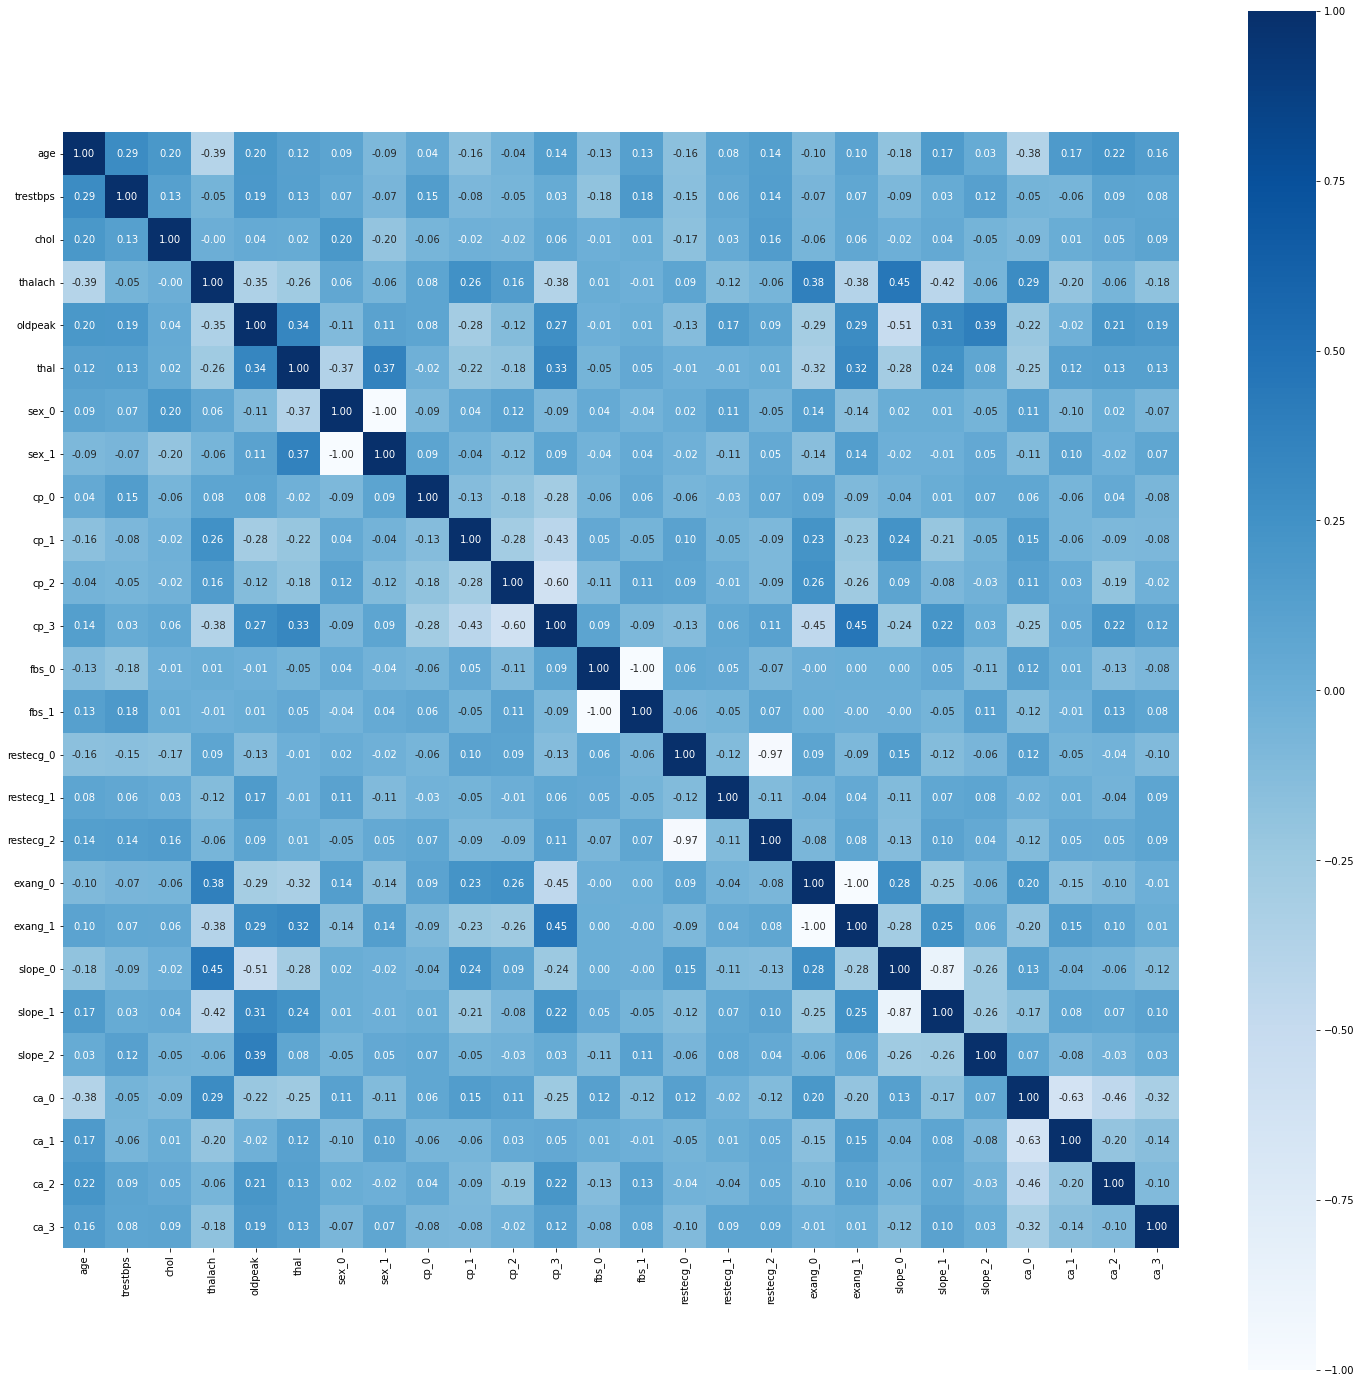

In [43]:
plt.figure(figsize = (25,25))
corr_values_ln = X.corr() 
sns.heatmap(corr_values_ln, annot=True,vmax=1, square=True, cmap="Blues",fmt='.2f')

In [44]:
upper_tri = corr_values_ln.where(np.triu(np.ones(corr_values_ln.shape),k=1).astype(np.bool))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [45]:
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.6)]

In [46]:
to_drop

['sex_1', 'fbs_1', 'restecg_2', 'exang_1', 'slope_1', 'ca_1']

In [47]:
X = X.drop(X[to_drop],axis=1)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Gradient Boosting Hyperparameter Tuning

In [49]:
# Number of trees in gradient boost
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier()
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 5, cv=10,verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [51]:
pprint(gb_random.best_params_)

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}


# MLP Hyperparameter Tuning

In [52]:
solver = ['lbfgs']
max_iter = [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
alpha = 10.0 ** -np.arange(1, 10)
hidden_layer_sizes = np.arange(10,100)

In [53]:
mlp_parameters = {'solver': solver, 'max_iter': max_iter, 'alpha': alpha, 'hidden_layer_sizes':hidden_layer_sizes}

In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
mlp = MLPClassifier()
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_parameters, n_iter = 5, cv=10,verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
mlp_random.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=10, estimator=MLPClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                                        'hidden_layer_sizes': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99]),
                                        'max_iter': [1000, 1100, 1200, 1300,
                                                     1400, 1500, 1600, 1700,
                                                     1800, 1900, 2000],
                                        'solver': ['lbfgs']},
                   random_state=42,

In [55]:
pprint(mlp_random.best_params_)

{'alpha': 1e-06, 'hidden_layer_sizes': 81, 'max_iter': 1300, 'solver': 'lbfgs'}


In [56]:
def fredman_rank(fredman):
  keys = list(fredman.keys())
  values = list(fredman.values())

  fredman_rank = {}
  for i in keys:
    fredman_rank[i] = 1
  
  max = 0
  for i,j in zip(range(len(values)),range(len(keys))):
    a = values[:i] + values[i+1:]
    for k in a:
      if k > values[i]:
        fredman_rank[keys[j]] += 1
  return fredman_rank

In [57]:
fredman_hd = {}

svm:0.83


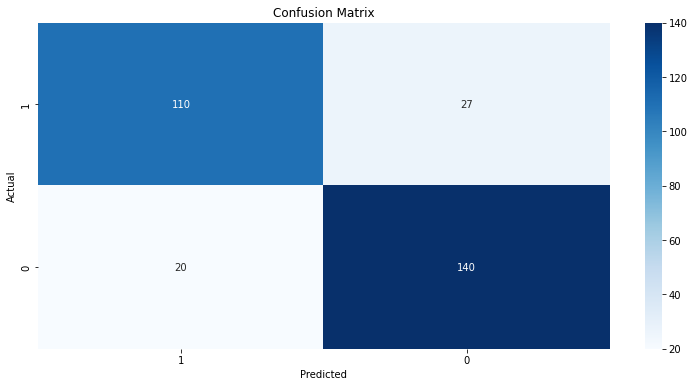

rf:0.83


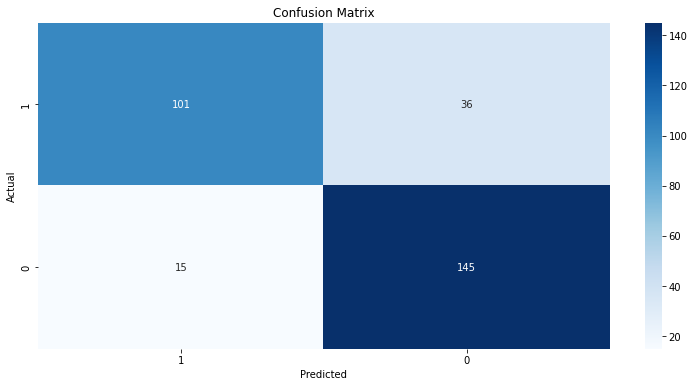

dt:0.75


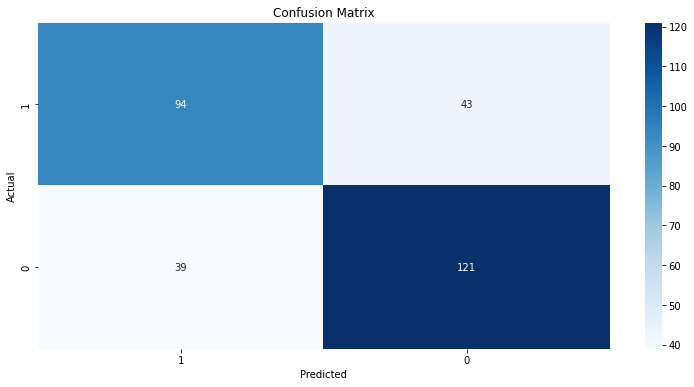

knn:0.79


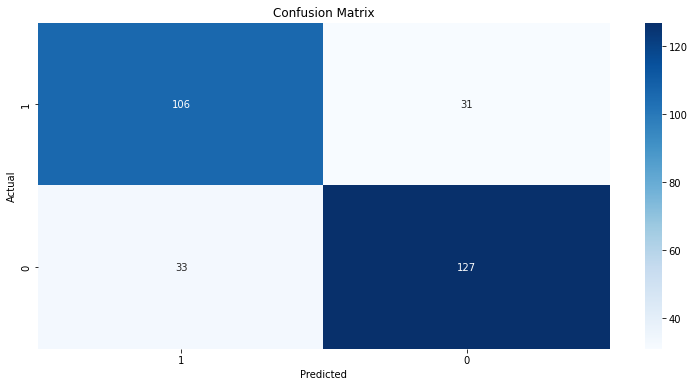

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

mlp:0.78


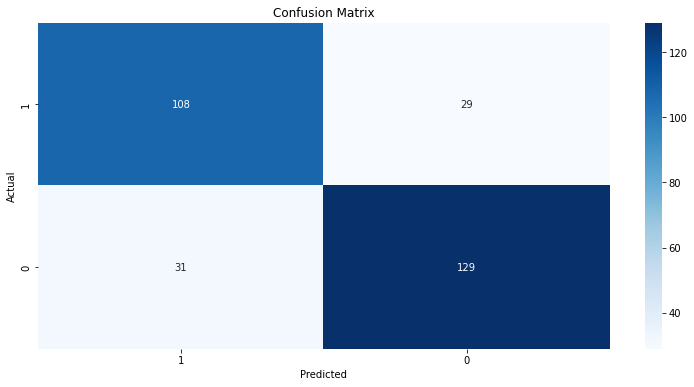

gb:0.78


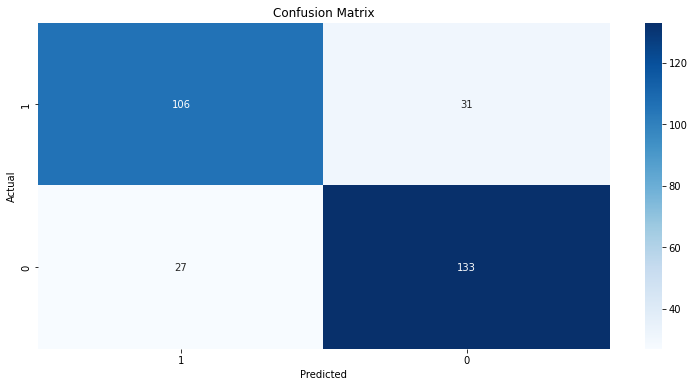

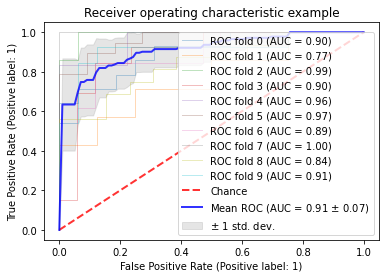

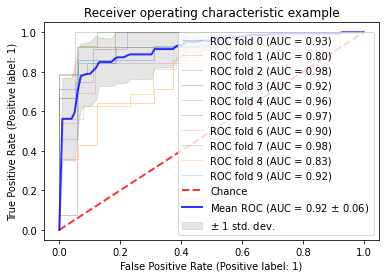

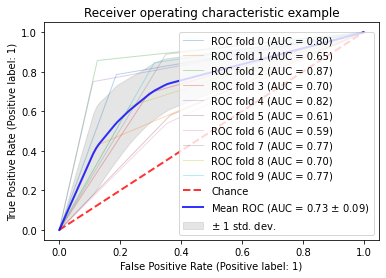

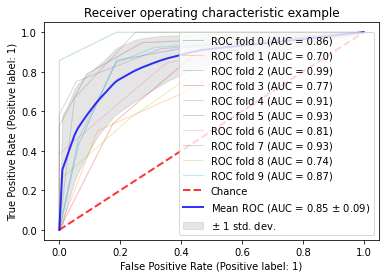

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

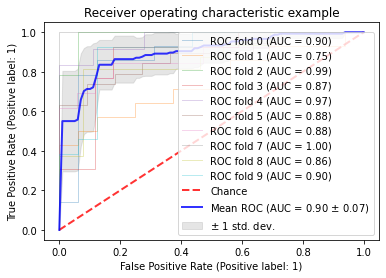

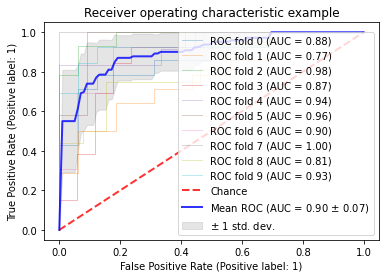

In [58]:
for i in range(len(label_hd)):
  y = df_hd[label_hd[i]]
  

  # x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
  labels = [1,0]

  #svm
  svm_clf = SVC(random_state = 42)
  result_svm = cross_val_predict(svm_clf,kfold,X,y)
  print('svm:' + str(result_svm[2]))
  plot_confusion_matrix(result_svm[0], result_svm[1], labels)
  fredman_hd['svm'] = result_svm[2]
  
  #rf
  rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
  result_rf = cross_val_predict(rf_clf,kfold,X,y)
  print('rf:' + str(result_rf[2]))
  plot_confusion_matrix(result_rf[0], result_rf[1], labels)
  fredman_hd['rf'] = result_rf[2]
  
  #dt
  dt_clf = DecisionTreeClassifier(random_state=0)
  result_dt = cross_val_predict(dt_clf,kfold,X,y)
  print('dt:' + str(result_dt[2]))
  plot_confusion_matrix(result_dt[0], result_dt[1], labels)
  fredman_hd['dt'] = result_dt[2]
  
  #knn
  knn_clf = KNeighborsClassifier(n_neighbors=3)
  result_knn = cross_val_predict(knn_clf,kfold,X,y)
  print('knn:' + str(result_knn[2]))
  plot_confusion_matrix(result_knn[0], result_knn[1], labels)
  fredman_hd['knn'] = result_knn[2]

  #mlp
  mlp_clf = MLPClassifier(random_state=1, alpha = 0.1, hidden_layer_sizes = 88, max_iter = 1200, solver = 'lbfgs')
  result_mlp = cross_val_predict(mlp_clf,kfold,X,y)
  print('mlp:' + str(result_mlp[2]))
  plot_confusion_matrix(result_mlp[0], result_mlp[1], labels)
  fredman_hd['mlp'] = result_mlp[2]

  #gb
  gb_clf = GradientBoostingClassifier(learning_rate=0.1, random_state=0,max_depth = 50,max_features = "sqrt",min_samples_leaf = 2,
  min_samples_split = 10,n_estimators = 200)
  result_gb = cross_val_predict(gb_clf,kfold,X,y)
  print('gb:' + str(result_gb[2]))
  plot_confusion_matrix(result_gb[0], result_gb[1], labels)
  fredman_hd['gb'] = result_gb[2]

  #create plots
  clfs = [svm_clf,rf_clf,dt_clf,knn_clf,mlp_clf,gb_clf]
  plot_cross_val_roc(kfold,clfs,X,y)

In [59]:
fredman_hd

{'svm': 0.83, 'rf': 0.83, 'dt': 0.75, 'knn': 0.79, 'mlp': 0.78, 'gb': 0.78}

In [60]:
fredman_hd_df = pd.DataFrame([fredman_hd])
fredman_hd_df

,svm,rf,dt,knn,mlp,gb
0,0.83,0.83,0.75,0.79,0.78,0.78


In [61]:
fredman_hd_rank = fredman_rank(fredman_hd)

In [62]:
fredman_hd_rank['dataset'] = 'heart disease'

In [63]:
fredman_hd_rank = pd.DataFrame([fredman_hd_rank])
fredman_hd_rank

,svm,rf,dt,knn,mlp,gb,dataset
0,1,1,6,3,4,4,heart disease


In [64]:
fredman_hd_df.to_csv('/content/drive/My Drive/5155-hw2/fredman_hd_df.csv',index=None)

In [65]:
fredman_hd_rank.to_csv('/content/drive/My Drive/5155-hw2/fredman_hd_rank.csv',index=None)